In [29]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from galaxybrain import ramsey, ising
from galaxybrain.plot_utils import rc_style, pltlabel, logaxes, colorcycler
rc_style()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ising model and scaling correlation analysis
Hamiltonian – rate of change in time of the condition of a dynamic physical system, or total energy in the system – is given by

\\[ H = -J\sum_{ij} s_is_j \\] 

Summing interactions between [4] neighbors, J (Strength of interaction in Joules) is usually 1 <br>
"In the case of an Ising system, instead of moving a particle, we switch the direction of its spin."

In each monte carlo sweep:
- "Propose" a move: (done in aggregate for each particle)
    - if ∆E < 0  (i.e., the move would bring the system to a state of lower energy; this is desired in physical systems), accept it
    - if ∆E > 0, accept move with probability exp(-∆E/kT) where k is Joules per kelvin.

let's try to do this vectorized

Furnstahl:  multiply every transition probability by 0.1 to avoid undesirable oscillatory regimes

References:
- https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf

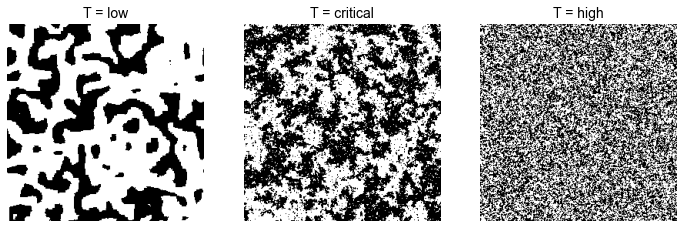

In [5]:
plt.figure(figsize=(12,4))
for i, temp in enumerate([0.1, 'critical', 5]):
    plt.subplot(1,3,i+1)
    grid = ising.metro_ising(N=256, T=temp, runtime=500)
    plt.imshow(grid[499], cmap='gray') # plot last frame
    title_map = {0.1:'low', 'critical':'critical', 5:'high'}
    plt.title(f'T = {title_map[temp]}', fontsize=14)
    plt.axis('off')
    
# plt.savefig('../fig/ising/grid_samples.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

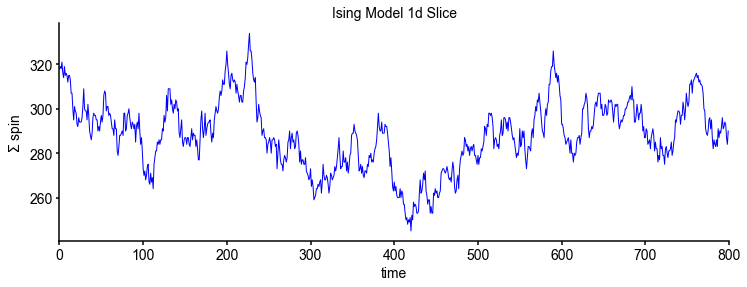

In [8]:
ising_raster = ising.metro_ising(N=650, T='critical', plot=False, runtime=1000)
## take a slice to imitate shape of mouse recordings
ising_raster_slice = pd.DataFrame(ising_raster[200:][:,325]) # shape (800, 650)

plt.figure(figsize=(12,4))
plt.plot(np.sum(ising_raster_slice.T), 'blue', lw=1)
plt.xlim([0,800])
pltlabel('Ising Model 1d Slice', 'time', r'$\Sigma$ spin')
# plt.savefig('../fig/ising/ts_sample.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Data from cluster

Iterated 5 times for each temperature in: 0.50, 1.00, 1.27, 1.47, 1.67, 1.87, 2.07, 2.27, 2.47, 2.67, 2.87, 3.07, 3.27, 5.00

In [10]:
from galaxybrain.data_utils import load_results

sim_data = load_results('../data/experiments/expSIM2', kind='sim')

{'n_iters': 95, 'n_pc': 0.8, 'f_range': [0, 0.4]}


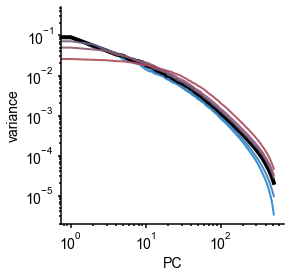

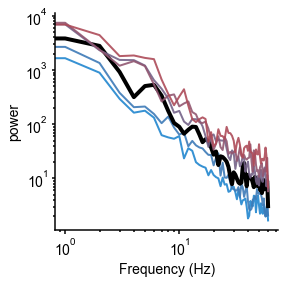

In [51]:
def plot_spectra(data, spec, temps='all', subset_ix=15):
    """plot spectra over temps given
    spec        : 'eigs' or 'pows'
    temps       : list of str temps or 'all'
    subset_ix : index in range [0, 16) """
    if temps == 'all':
        temps = [k for k in data if k != 'meta']

    data = {k : data[k] for k in temps} # filter
    colors = colorcycler(['#2186cf', '#ad4b59'], len(data), False)
    plt.figure(figsize=(4,4))
    for i, t in enumerate(data):
        # conditionals for plot
        lw    =  4  if t=='2.27' else 2
        alpha =  1  if t=='2.27' else 0.9
        color = 'k' if t=='2.27' else colors[i]
        plt.plot(data[t]['data'][spec][subset_ix], color=color, lw=lw, alpha=alpha)
        logaxes()
        
    
sample_temps = ['1.67', '1.87', '2.27', '2.67', '3.07', '5.00']
plot_spectra(sim_data, 'eigs', sample_temps)
pltlabel('','PC', 'variance')
plt.savefig('../fig/ising/es_sample.png', bbox_inches='tight', pad_inches=0.0, dpi=400)
plot_spectra(sim_data, 'pows', sample_temps)
pltlabel('','Frequency (Hz)', 'power')
plt.savefig('../fig/ising/psd_sample.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# summary heatmap

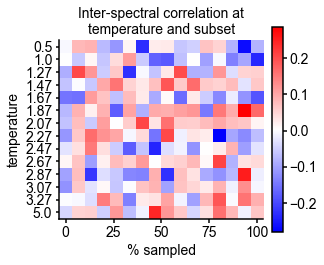

In [41]:
corr_mat = [sim_data[temp]['data']['pearson_corr'].mean(0) 
                    for temp in sim_data.keys()]
plt.figure()
plt.imshow(corr_mat, 'bwr')
plt.xticks(ticks=np.linspace(0,15,5) , labels=np.linspace(0,100,5,dtype=int))#subset_sizes/max(subset_sizes))
plt.yticks(ticks=range(len(sim_data.keys())), labels=list(map(float, sim_data.keys())))
plt.ylim((len(sim_data.keys())-0.5, -0.5)) # weird bug: imshow y axis gets cut off so have to force ylim
plt.colorbar(fraction=0.046, pad=0.04)
pltlabel('Inter-spectral correlation at\ntemperature and subset', '% sampled','temperature')
# plt.savefig('../fig/ising/corr_heatmap.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

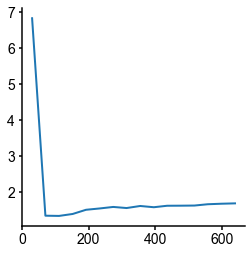

In [47]:
subset_sizes = sim_data['1.00']['meta']['subsetsizes'] #arbitrary temperature

plt.plot(subset_sizes, sim_data['1.00']['data']['espec_exp'][0])

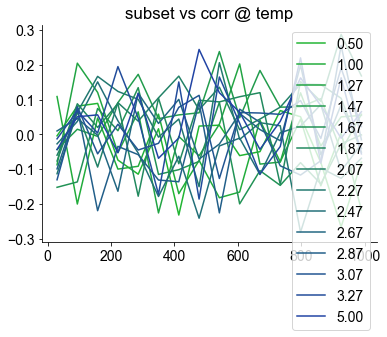

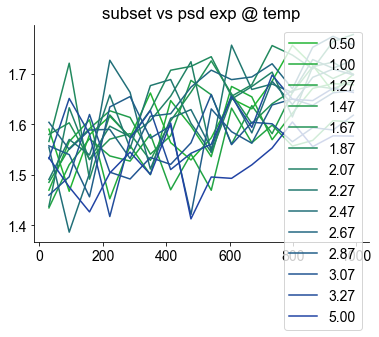

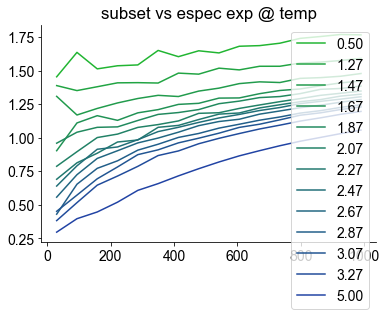

In [39]:
from matplotlib.colors import LinearSegmentedColormap

subset_sizes = sim_data['1.00']['meta']['subsetsizes'] #arbitrary temperature
cmap = LinearSegmentedColormap.from_list('mycmap', ['#21b532', '#2132b5'])(np.linspace(0, 1, len(subset_sizes)))
for i, temp in enumerate(sim_data.keys()):
    plt.plot(subset_sizes, sim_data[temp]['data']['pearson_corr'].mean(0), color=cmap[i], label=temp)
pltlabel('subset vs corr @ temp', '','')
plt.legend()

plt.figure()
for i, temp in enumerate(sim_data.keys()):
    plt.plot(subset_sizes, sim_data[temp]['data']['psd_exp'][0], color=cmap[i], label=temp)
pltlabel('subset vs psd exp @ temp','','')
plt.legend()

plt.figure()
for i, temp in enumerate(sim_data.keys()):
    if temp == '1.00': continue # this one is messed up for some reason
    plt.plot(subset_sizes, sim_data[temp]['data']['espec_exp'][0], color=cmap[i], label=temp)
pltlabel('subset vs espec exp @ temp','','')
plt.legend()